In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
from matplotlib import pyplot as plt

In [3]:
df_equi = pd.read_excel("df_equi.xlsx", index_col = 0)

avg_p = []
for i in range(96):
    df = df_equi.iloc[i*24:(i+1)*24]
    a = df['bp1_p'].mean()
    avg_p.append(a)

In [4]:
#首先利用单位根检验（ADF）判断时间序列是否平稳
#原假设是存在单位根，不平稳
from statsmodels.tsa.stattools import adfuller
avg_result = adfuller(avg_p)#生成adf单位根检验结果
print('The ADF Statistic of average price for price1: %f' % avg_result[0])
print('The p value of average price: %f' % avg_result[1])

The ADF Statistic of average price for price1: -3.345171
The p value of average price: 0.012976


- 单位根检验结果p-value=0.012976<0.05, 得出数据为平稳的时间序列。

In [7]:
import warnings
warnings.filterwarnings('ignore')
from statsmodels.stats.diagnostic import acorr_ljungbox #白噪声检验
print('The result of white noise：', acorr_ljungbox(avg_p, lags=1)) #返回统计量和p值

The result of white noise： (array([8.7308608]), array([0.00312869]))


- 白噪声检验p-value远小于0.05，因此时间序列为平稳非白噪声序列。

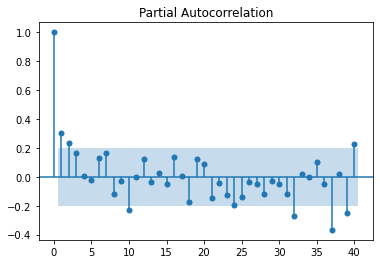

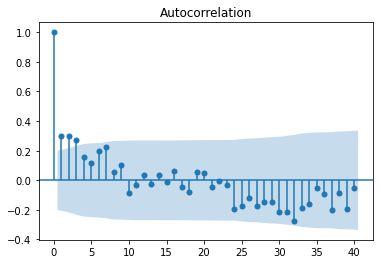

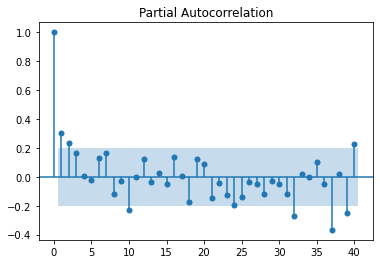

In [13]:
####自相关图ACF和偏相关图PACF
import statsmodels.api as sm
sm.graphics.tsa.plot_acf(avg_p,lags=40) #ARIMA,q
sm.graphics.tsa.plot_pacf(avg_p,lags=40) #ARIMA,p
 #查看数据的自相关图和偏自相关图

- 从图像得出ACF以及PACF都是拖尾，因此采用ARMA(p,q)模型。

In [10]:
#利用自带function确定p和q：
import statsmodels.tsa.stattools as st
order = st.arma_order_select_ic(avg_p,max_ar=5,max_ma=5,ic=['aic', 'bic', 'hqic'])
order.bic_min_order


(1, 1)

Text(0.5, 1.0, 'RSS:152277.2550')

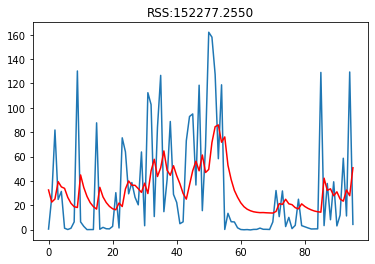

In [18]:
# 采用ARMA(1,1)模型
#RSS是残差平方和
# disp为-1代表不输出收敛过程的信息，True代表输出
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(avg_p,order=(1,0,1)) 
results_AR = model.fit(disp=-1)
plt.plot(avg_p)
plt.plot(results_AR.fittedvalues, color='red') #红色线代表预测值
plt.title('RSS:%.4f' % sum((results_AR.fittedvalues-avg_p)**2))#残差平方和

In [20]:
results_AR.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: ARMA
==================================================================
Model:              ARMA             BIC:                 998.2358
Dependent Variable: y                Log-Likelihood:      -489.99 
Date:               2022-04-26 23:51 Scale:               1.0000  
No. Observations:   96               Method:              css-mle 
Df Model:           3                Sample:              0       
Df Residuals:       93                                    6       
Converged:          1.0000           S.D. of innovations: 39.798  
No. Iterations:     34.0000          HQIC:                992.125 
AIC:                987.9784                                      
--------------------------------------------------------------------
            Coef.    Std.Err.      t      P>|t|     [0.025    0.975]
--------------------------------------------------------------------
const      32.5423     9.5202    3.4182   0.0006   13.8831   51.2016
ar.L1.y     0.8476     0.0990    8.5617   0.0000    0.6536    1.0416
ma.L1.y    -0.6287     0.1428   -4.4042   0.0000   -0.9085   -0.3489
---------------------------------------------------------------------------
               Real           Imaginary          Modulus          Frequency
---------------------------------------------------------------------------
AR.1          1.1798             0.0000           1.1798             0.0000
MA.1          1.5906             0.0000           1.5906             0.0000
==================================================================

"""

- 模型系数都是显著的，但是从图像来看，拟合程度有待提高。虽然数据一开始通过了平稳性检验，但是从图像来看可以利用差分将数据继续平稳化。

In [62]:
def diff(lst):#定义一个差分函数
    diff_list=[]
    for i in range(1,len(lst)):
        a = lst[i-1]-lst[i]
        diff_list.append(a)
    return diff_list

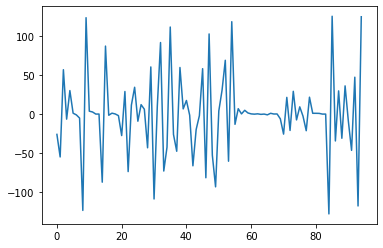

In [55]:
#一阶差分图像：
plt.plot(diff(avg_p));

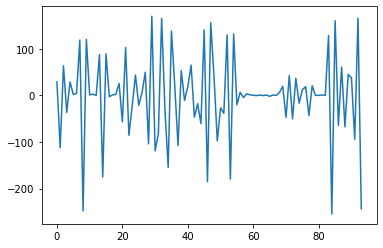

In [56]:
#二阶差分图像：
plt.plot(diff(diff(avg_p)));

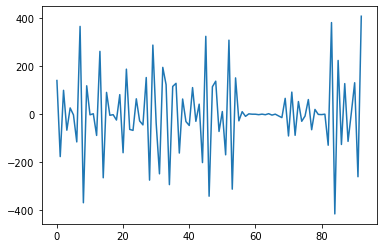

In [57]:
#三阶差分图像：
plt.plot(diff(diff(diff(avg_p))));

- 根据图像，判断得出差分后数据更平稳，并且多阶差分对平稳性影响不大，因此尝试选择一阶差分做模型预测。

In [58]:
#对差分数据做平稳性检验：
avg_result = adfuller(diff(avg_p))#生成adf单位根检验结果
print('The ADF Statistic of average price for price1: %f' % avg_result[0])
print('The p value of average price: %f' % avg_result[1])

The ADF Statistic of average price for price1: -11.361684
The p value of average price: 0.000000


- p-value接近0，数据平稳性确实有显著的提高。

In [59]:
#确定差分模型参数
df_diff = diff(avg_p)
order = st.arma_order_select_ic(df_diff,max_ar=5,max_ma=5,ic=['aic', 'bic', 'hqic'])
order.bic_min_order

(0, 1)

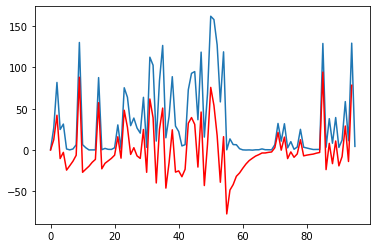

In [76]:
# 采用ARMA(0,1,1)模型
#RSS是残差平方和
# disp为-1代表不输出收敛过程的信息，True代表输出
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(avg_p,order=(0,1,1)) 
results_AR = model.fit(disp=-1)

plt.plot(avg_p)
plt.plot(-1*results_AR.fittedvalues, color='red') #红色线代表预测值

In [77]:
results_AR.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: ARIMA
==================================================================
Model:              ARIMA            BIC:                 989.9067
Dependent Variable: D.y              Log-Likelihood:      -488.12 
Date:               2022-04-27 00:36 Scale:               1.0000  
No. Observations:   95               Method:              css-mle 
Df Model:           2                Sample:              1       
Df Residuals:       93                                    6       
Converged:          1.0000           S.D. of innovations: 41.049  
No. Iterations:     6.0000           HQIC:                985.341 
AIC:                982.2451                                      
-------------------------------------------------------------------
                Coef.   Std.Err.     t     P>|t|    [0.025   0.975]
-------------------------------------------------------------------
const           0.1589    1.0727   0.1482  0.8822  -1.9436   2.2615
ma.L1.D.y      -0.7537    0.0794  -9.4957  0.0000  -0.9093  -0.5982
---------------------------------------------------------------------------
               Real           Imaginary          Modulus          Frequency
---------------------------------------------------------------------------
MA.1          1.3267             0.0000           1.3267             0.0000
==================================================================

"""

- 拟合作效果依然不好，可能是bp1_p本身数据的问题。
- 将预测过程functionalize，查看其他四个点的情况。

In [91]:
def get_ts(n,summary=False):
    df_equi = pd.read_excel("df_equi.xlsx", index_col = 0)

    avg_p = []
    for i in range(96):
        df = df_equi.iloc[i*24:(i+1)*24]
        a = df['bp'+str(n)+'_p'].mean()
        avg_p.append(a)
    import statsmodels.tsa.stattools as st
    order = st.arma_order_select_ic(avg_p,max_ar=5,max_ma=5,ic=['aic', 'bic', 'hqic'])
    (p,q) = order.bic_min_order
    from statsmodels.tsa.arima_model import ARIMA
    model = ARIMA(avg_p,order=(p,0,q)) 
    results_AR = model.fit(disp=-1)
    if summary:
        results_AR.summary2()
    else:
        plt.plot(avg_p)
        plt.plot(results_AR.fittedvalues, color='red') #红色线代表预测值
        plt.title('RSS:%.4f' % sum((results_AR.fittedvalues-avg_p)**2))#残差平方和

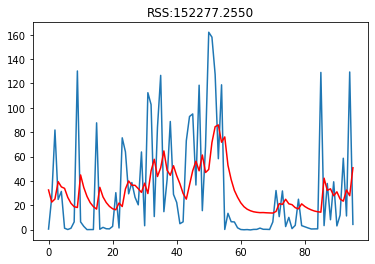

In [92]:
get_ts(1)

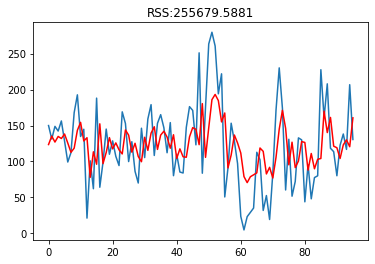

In [93]:
get_ts(2)

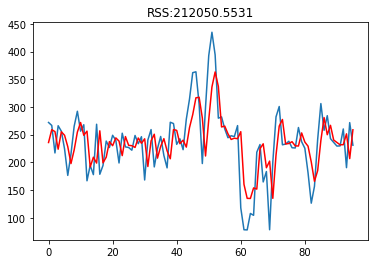

In [94]:
get_ts(3)

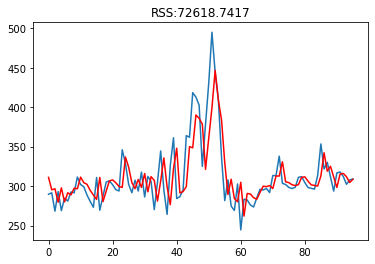

In [95]:
get_ts(4)

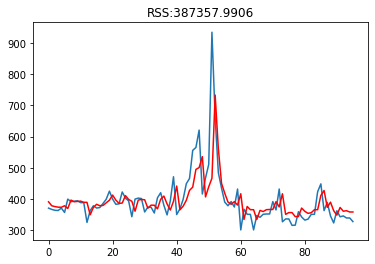

In [96]:
get_ts(5)

- 红色线是模型预测线。
- 3，4，5完全没问题，差不多可以用了。
- 1，2需要重新拟合，调参数或者换model。

Text(0.5, 1.0, 'RSS:81.3767')

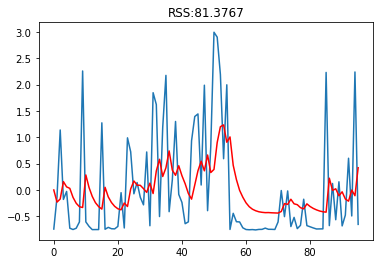

In [99]:
#用标准化数据做一下试试(With new dataset)：
df_equi = pd.read_excel("df_equi.xlsx", index_col = 0)

avg_p = []
for i in range(96):
    df = df_equi.iloc[i*24:(i+1)*24]
    a = df['bp1_p'].mean()
    avg_p.append(a)
a = np.mean(avg_p)
b = np.std(avg_p)
avg_std = []
for i in avg_p:
    avg_std.append((i-a)/b)
order = st.arma_order_select_ic(avg_std,max_ar=5,max_ma=5,ic=['aic', 'bic', 'hqic'])
(p,q) = order.bic_min_order
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(avg_std,order=(p,0,q)) 
results_AR = model.fit(disp=-1)
plt.plot(avg_std)
plt.plot(results_AR.fittedvalues, color='red') #红色线代表预测值
plt.title('RSS:%.4f' % sum((results_AR.fittedvalues-avg_std)**2))#残差平方和

In [114]:
#Functionalize看剩下的点：
def get_ts_std(n,summary=False):
    df_equi = pd.read_excel("df_equi1.xlsx", index_col = 0)
    avg_p = []
    for i in range(96):
        df = df_equi.iloc[i*24:(i+1)*24]
        a = df['bp'+str(n)+'_p'].mean()
        avg_p.append(a)
    a = np.mean(avg_p)
    b = np.std(avg_p)
    avg_std = []
    for i in avg_p:
        avg_std.append((i-a)/b)
    order = st.arma_order_select_ic(avg_std,max_ar=5,max_ma=5,ic=['aic', 'bic', 'hqic'])
    (p,q) = order.bic_min_order
    from statsmodels.tsa.arima_model import ARIMA
    model = ARIMA(avg_std,order=(p,0,q)) 
    results_AR = model.fit(disp=-1)
    from sklearn.metrics import r2_score#R 2
    r2 = r2_score(avg_std,results_AR.fittedvalues)
    if summary:
        results_AR.summary2()
    
    else:
        plt.plot(avg_std)
        plt.plot(results_AR.fittedvalues, color='red') #红色线代表预测值
        plt.title('R2:%.4f' % r2)#残差平方和

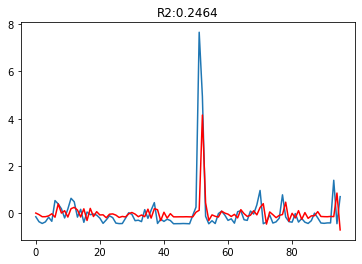

In [116]:
get_ts_std(2)

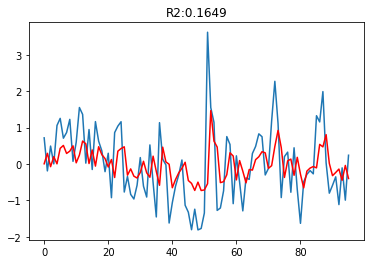

In [117]:
get_ts_std(3)

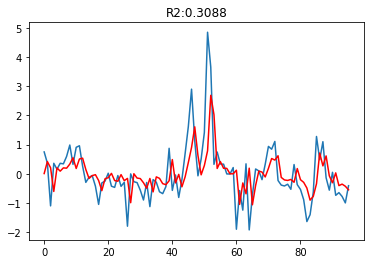

In [118]:
get_ts_std(4)

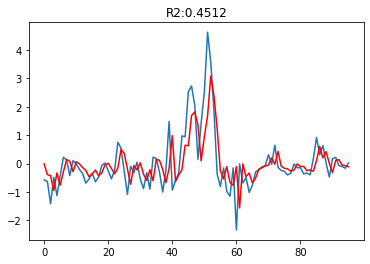

In [119]:
get_ts_std(5)

In [206]:
#优化一下function
def get_ts_std(n,summary=False):
    import numpy as np
    from scipy import stats
    df_equi = pd.read_excel("df_equi1.xlsx", index_col = 0)
    avg_p = []
    for i in range(96):
        df = df_equi.iloc[i*24:(i+1)*24]
        a = list(df['bp'+str(n)+'_p'])
        b = np.mean(a)
        avg_p.append(b)
    avg_p.remove(max(avg_p))
#     avg_p.remove(max(avg_p))
    

    order = st.arma_order_select_ic(avg_p,max_ar=5,max_ma=5,ic=['aic', 'bic', 'hqic'])
    (p,q) = order.bic_min_order
    from statsmodels.tsa.arima_model import ARIMA
    model = ARIMA(avg_p,order=(p,0,q)) 
    results_AR = model.fit(disp=-1)
    from sklearn.metrics import r2_score#R 2
    r2 = r2_score(avg_p,results_AR.fittedvalues)
    if summary:
        return results_AR.summary2()
    
    else:
        plt.plot(avg_p)
        plt.plot(results_AR.fittedvalues, color='red') #红色线代表预测值
        plt.title('R2:%.4f' % r2)#残差平方和

In [191]:
get_ts_std(2,1)

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: ARMA
==================================================================
Model:              ARMA             BIC:                 669.8063
Dependent Variable: y                Log-Likelihood:      -330.36 
Date:               2022-04-27 15:22 Scale:               1.0000  
No. Observations:   94               Method:              css     
Df Model:           1                Sample:              0       
Df Residuals:       93                                    4       
Converged:          1.0000           S.D. of innovations: 8.130   
No. Iterations:     0.0000           HQIC:                666.774 
AIC:                664.7197                                      
---------------------------------------------------------------------
           Coef.     Std.Err.      t       P>|t|     [0.025    0.975]
---------------------------------------------------------------------
const      7.0707      0.8385    8.4324    0.0000    5.4273    8.7142
==================================================================

"""

In [199]:
df_equi = pd.read_excel("df_equi1.xlsx", index_col = 0)

In [200]:
#首先利用单位根检验（ADF）判断时间序列是否平稳
#原假设是存在单位根，不平稳
from statsmodels.tsa.stattools import adfuller
avg_p2 = []
for i in range(96):
    df = df_equi.iloc[i*24:(i+1)*24]
    a = list(df['bp2_p'])
    b = np.mean(a)
    avg_p2.append(b)
# avg_p2.remove(max(avg_p2))
avg_p2.remove(max(avg_p2))
avg_result = adfuller(avg_p2)#生成adf单位根检验结果
print('The ADF Statistic of average price for price1: %f' % avg_result[0])
print('The p value of average price: %f' % avg_result[1])

The ADF Statistic of average price for price1: -9.477542
The p value of average price: 0.000000


In [201]:
import warnings
warnings.filterwarnings('ignore')
from statsmodels.stats.diagnostic import acorr_ljungbox #白噪声检验
print('The result of white noise：', acorr_ljungbox(avg_p2, lags=1)) #返回统计量和p值

The result of white noise： (array([4.46977726e-05]), array([0.99466567]))


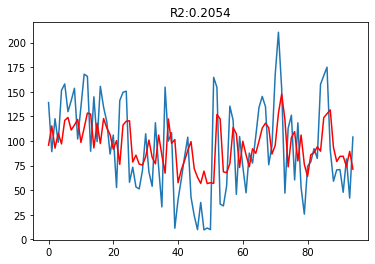

In [207]:
get_ts_std(3)

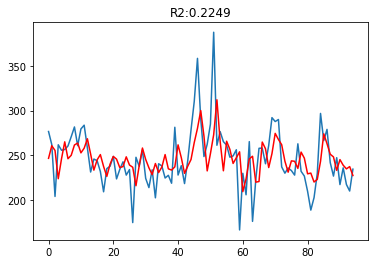

In [208]:
get_ts_std(4)

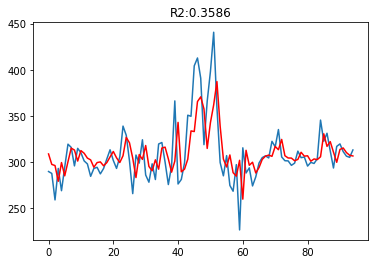

In [209]:
get_ts_std(5)

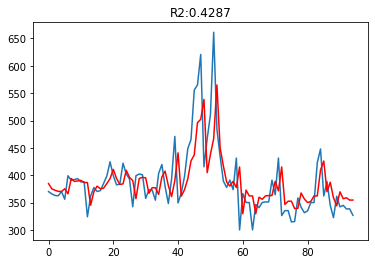

In [210]:
get_ts_std(6)

In [211]:
#用function方法选取参数再试一下：
#定阶
# pmax  =  int(len(df["失业率"])/10)  #一般阶数不超过length/10
# qmax  =  int(len(df["失业率"])/10)  #一般阶数不超过length/10
df_equi = pd.read_excel("df_equi1.xlsx", index_col = 0)
avg_p = []
for i in range(96):
    df = df_equi.iloc[i*24:(i+1)*24]
    a = list(df['bp6_p'])
    b = np.mean(a)
    avg_p.append(b)
pmax = 5
qmax = 5
bic_matrix  =  []  #bic矩阵
for  p  in  range(pmax+1):
    tmp  =  []
    for  q  in  range(qmax+1):  #存在部分报错，所以用try来跳过报错。
        try:
            tmp.append(ARIMA(avg_p,order=(p,0,q)).fit().bic) 
        except:
            tmp.append(None)
    bic_matrix.append(tmp)
bic_matrix  =  pd.DataFrame(bic_matrix)  #从中可以找出最小值
p,q  =  bic_matrix.stack().idxmin()  
# #先用stack展平，然后用idxmin找出最小值位置。
print(u'BIC最小的p值和q值为：%s、%s'  %(p,q))
#定阶
# pmax  =  int(len(df["失业率"])/10)  #一般阶数不超过length/10
# qmax  =  int(len(df["失业率"])/10)  #一般阶数不超过length/10
pmax = 5
qmax = 5
aic_matrix  =  []  #bic矩阵
for  p  in  range(pmax+1):
    tmp  =  []
    for  q  in  range(qmax+1):  #存在部分报错，所以用try来跳过报错。
        try:
            tmp.append(ARIMA(avg_p,order=(p,0,q)).fit().aic) 
        except:
            tmp.append(None)
    aic_matrix.append(tmp)
aic_matrix  =  pd.DataFrame(bic_matrix)  #从中可以找出最小值
p,q  =  bic_matrix.stack().idxmin()  
# #先用stack展平，然后用idxmin找出最小值位置。
print(u'AIC最小的p值和q值为：%s、%s'  %(p,q))

BIC最小的p值和q值为：1、0
AIC最小的p值和q值为：1、0


Text(0.5, 1.0, 'R2:0.5260')

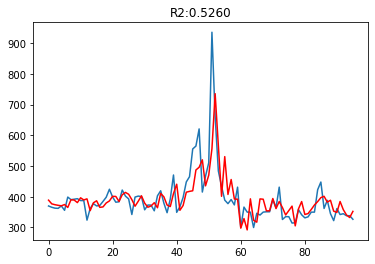

In [222]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(avg_p,order=(15,0,10)) 
results_AR = model.fit(disp=-1)
from sklearn.metrics import r2_score#R 2
r2 = r2_score(avg_p,results_AR.fittedvalues)
plt.plot(avg_p)
plt.plot(results_AR.fittedvalues, color='red') #红色线代表预测值
plt.title('R2:%.4f' % r2)#残差平方和

(array([1.858e+03, 3.480e+02, 5.500e+01, 2.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 7.000e+00, 3.300e+01]),
 array([  0. ,  19.5,  39. ,  58.5,  78. ,  97.5, 117. , 136.5, 156. ,
        175.5, 195. ]),
 <BarContainer object of 10 artists>)

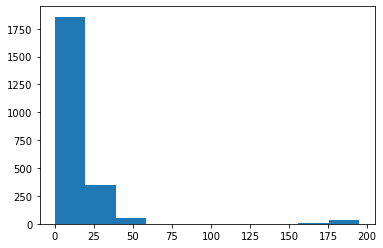

In [224]:
df_equi = pd.read_excel("df_equi1.xlsx", index_col = 0)
plt.hist(df_equi['bp2_p'])

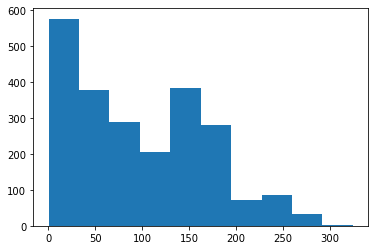

In [225]:
plt.hist(df_equi['bp3_p']);

In [243]:
import ast
a = list(pd.DataFrame(df_equi.loc['20220203 18:00']).loc['UNITPRICE'])[0]
a = ast.literal_eval(a)
b = list(pd.DataFrame(df_equi.loc['20220203 18:00']).loc['QUANTITY'])[0]
b = ast.literal_eval(b)

In [247]:
lst = []
for i in range(166):
    lst.append((a[i],b[i]))
lst

[(-500.0, 0.0),
 (-500.0, 3364.55),
 (-150.0, 3364.55),
 (-150.0, 3400.55),
 (-50.0, 3400.55),
 (-50.0, 3403.55),
 (-25.0, 3403.55),
 (-25.0, 3489.61),
 (-4.0, 3489.61),
 (-4.0, 3774.94),
 (-3.0, 3774.94),
 (-3.0, 3816.04),
 (-0.01, 3881.1215),
 (-0.01, 4017.6415),
 (0.0, 4018.6741),
 (0.0, 4407.2871),
 (0.01, 4421.3568),
 (0.01, 4426.0888),
 (0.51, 4436.972),
 (0.9, 4436.972),
 (1.0, 4441.972),
 (82.58, 4441.972),
 (82.58, 4454.972),
 (82.59, 4454.972),
 (82.59, 4459.972),
 (82.6, 4459.972),
 (82.6, 4564.972),
 (105.69, 4564.972),
 (105.7, 4565.972),
 (148.16, 4565.972),
 (148.16, 4645.972),
 (153.16, 4645.972),
 (153.16, 4688.972),
 (181.57, 4688.972),
 (181.57, 4706.972),
 (185.06, 4706.972),
 (185.06, 4724.972),
 (194.89, 4724.972),
 (199.89, 4727.972),
 (203.0, 4737.613),
 (203.0, 4827.613),
 (205.9, 4838.5109),
 (206.7, 4891.5172),
 (206.9, 4892.8167),
 (207.7, 4948.0148),
 (214.0, 5008.9498),
 (219.89, 5047.4094),
 (229.89, 5126.7057),
 (229.9, 5126.74),
 (230.0, 5127.3802),
 (2

In [238]:
list(pd.DataFrame(df_equi.loc['20220203 18:00']).loc['QUANTITY'])

['[0.0, 3364.55, 3364.55, 3400.55, 3400.55, 3403.55, 3403.55, 3489.61, 3489.61, 3774.94, 3774.94, 3816.04, 3881.1215, 4017.6415, 4018.6741, 4407.2871, 4421.3568, 4426.0888, 4436.972, 4436.972, 4441.972, 4441.972, 4454.972, 4454.972, 4459.972, 4459.972, 4564.972, 4564.972, 4565.972, 4565.972, 4645.972, 4645.972, 4688.972, 4688.972, 4706.972, 4706.972, 4724.972, 4724.972, 4727.972, 4737.613, 4827.613, 4838.5109, 4891.5172, 4892.8167, 4948.0148, 5008.9498, 5047.4094, 5126.7057, 5126.74, 5127.3802, 5134.7304, 5248.7304, 5250.4309, 5375.4309, 5377.7895, 5494.7895, 5531.3761, 5629.3761, 5641.7179, 5729.4735, 5772.0739, 5798.3902, 5854.8148, 5954.8148, 5961.6008, 5986.9757, 5987.2757, 6012.2757, 6021.536, 6046.5735, 6055.4215, 6080.4215, 6083.5333, 6108.5333, 6112.3949, 6122.3949, 6133.6424, 6213.6424, 6214.1673, 6239.1673, 6242.279, 6267.279, 6272.1154, 6274.3284, 6299.3284, 6308.3, 6408.3, 6410.6027, 6435.6326, 6436.2008, 6461.2008, 6461.7092, 6486.7092, 6489.6997, 6489.7154, 6569.7154, 656

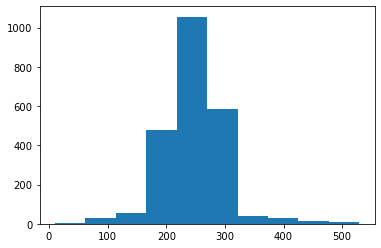

In [226]:
plt.hist(df_equi['bp4_p']);

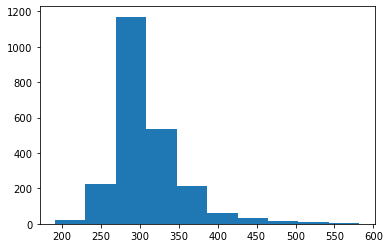

In [227]:
plt.hist(df_equi['bp5_p']);

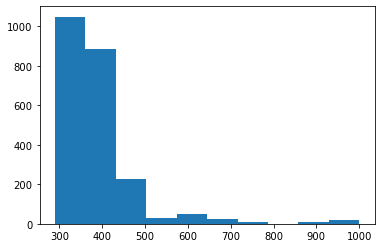

In [228]:
plt.hist(df_equi['bp6_p']);

In [261]:
def get_ts_std(n,m=0,summary=False):
    import numpy as np
    from scipy import stats
    df_equi = pd.read_excel("df_equi2.xlsx", index_col = 0)
    avg_p = []
    for i in range(96):
        df = df_equi.iloc[i*24:(i+1)*24]
        a = list(df['bp'+str(n)+'_p'])
        b = np.mean(a)
        avg_p.append(b)
    for i in range(m):
        avg_p.remove(max(avg_p))
    

    order = st.arma_order_select_ic(avg_p,max_ar=5,max_ma=5,ic=['aic', 'bic', 'hqic'])
    (p,q) = order.bic_min_order
    from statsmodels.tsa.arima_model import ARIMA
    model = ARIMA(avg_p,order=(p,0,q)) 
    results_AR = model.fit(disp=-1)
    from sklearn.metrics import r2_score#R 2
    r2 = r2_score(avg_p,results_AR.fittedvalues)
    if summary:
        return results_AR.summary2()
    
    else:
        plt.plot(avg_p)
        plt.plot(results_AR.fittedvalues, color='red') #红色线代表预测值
        plt.title('R2:%.4f' % r2)#残差平方和

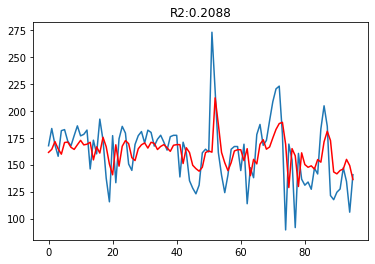

In [264]:
get_ts_std(3)

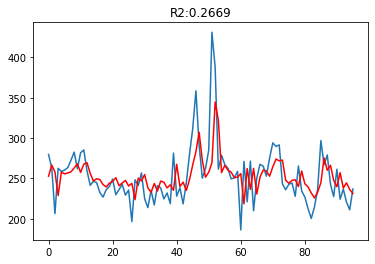

In [267]:
get_ts_std(4)

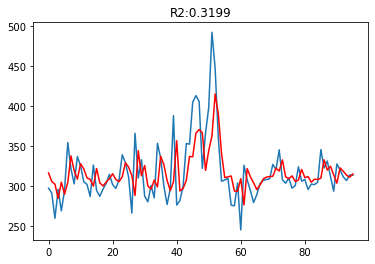

In [270]:
get_ts_std(5)

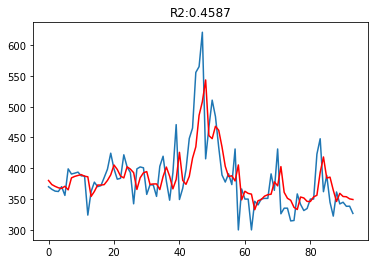

In [278]:
get_ts_std(6,2)

In [281]:
def get_ts_whole(n,m=0,summary=False):
    import numpy as np
    from scipy import stats
    df_equi = pd.read_excel("df_equi2.xlsx", index_col = 0)
    avg_p = list(df_equi['bp'+str(n)+'_p'])
    for i in range(m):
        avg_p.remove(max(avg_p))

    order = st.arma_order_select_ic(avg_p,max_ar=5,max_ma=5,ic=['aic', 'bic', 'hqic'])
    (p,q) = order.bic_min_order
    from statsmodels.tsa.arima_model import ARIMA
    model = ARIMA(avg_p,order=(p,0,q)) 
    results_AR = model.fit(disp=-1)
    from sklearn.metrics import r2_score#R 2
    r2 = r2_score(avg_p,results_AR.fittedvalues)
    if summary:
        return results_AR.summary2()
    
    else:
        plt.plot(avg_p)
        plt.plot(results_AR.fittedvalues, color='red') #红色线代表预测值
        plt.title('R2:%.4f' % r2)#残差平方和

In [288]:
get_ts_whole(6,0,1)

<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: ARMA
====================================================================
Model:              ARMA             BIC:                 23068.6282
Dependent Variable: y                Log-Likelihood:      -11515.   
Date:               2022-04-27 18:25 Scale:               1.0000    
No. Observations:   2304             Method:              css-mle   
Df Model:           4                Sample:              0         
Df Residuals:       2300                                  4         
Converged:          1.0000           S.D. of innovations: 35.818    
No. Iterations:     23.0000          HQIC:                23050.383 
AIC:                23039.9162                                      
---------------------------------------------------------------------
              Coef.    Std.Err.     t      P>|t|    [0.025    0.975] 
---------------------------------------------------------------------
const        390.0217   17.2418   22.6206  0.0000  356.2283  423.8151
ar.L1.y        1.5941    0.0421   37.9047  0.0000    1.5116    1.6765
ar.L2.y       -0.6013    0.0404  -14.8878  0.0000   -0.6805   -0.5222
ma.L1.y       -0.8282    0.0318  -26.0556  0.0000   -0.8905   -0.7659
-----------------------------------------------------------------------------
                 Real           Imaginary          Modulus          Frequency
-----------------------------------------------------------------------------
AR.1            1.0192             0.0000           1.0192             0.0000
AR.2            1.6317             0.0000           1.6317             0.0000
MA.1            1.2074             0.0000           1.2074             0.0000
====================================================================

"""

In [58]:
import pandas as pd
df_equi = pd.read_excel("df_equi2.xlsx", index_col = 0)
avg_p = df_equi['bp6_p']
test_ratio = 0.25
test_size = int(avg_p.shape[0]*test_ratio)
train_size = avg_p.shape[0] - test_size
train_set = avg_p[:train_size].values
test_set = avg_p[train_size:].values

In [59]:
len(test_set)

576

In [13]:
import numpy as np
import statsmodels.tsa.stattools as st
from scipy import stats
order = st.arma_order_select_ic(train_set,max_ar=5,max_ma=5,ic=['aic', 'bic', 'hqic'])
(p,q) = order.bic_min_order
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(train_set,order=(p,0,q)) 
results_AR = model.fit(disp=-1)
results_AR.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: ARMA
====================================================================
Model:              ARMA             BIC:                 22022.3708
Dependent Variable: y                Log-Likelihood:      -10992.   
Date:               2022-04-27 20:15 Scale:               1.0000    
No. Observations:   2189             Method:              css-mle   
Df Model:           4                Sample:              0         
Df Residuals:       2185                                  9         
Converged:          1.0000           S.D. of innovations: 36.674    
No. Iterations:     24.0000          HQIC:                22004.316 
AIC:                21993.9148                                      
---------------------------------------------------------------------
              Coef.    Std.Err.     t      P>|t|    [0.025    0.975] 
---------------------------------------------------------------------
const        392.8796   17.6402   22.2719  0.0000  358.3056  427.4537
ar.L1.y        1.5916    0.0436   36.4634  0.0000    1.5060    1.6771
ar.L2.y       -0.5991    0.0419  -14.3080  0.0000   -0.6812   -0.5171
ma.L1.y       -0.8261    0.0331  -24.9331  0.0000   -0.8911   -0.7612
-----------------------------------------------------------------------------
                 Real           Imaginary          Modulus          Frequency
-----------------------------------------------------------------------------
AR.1            1.0198             0.0000           1.0198             0.0000
AR.2            1.6366             0.0000           1.6366             0.0000
MA.1            1.2105             0.0000           1.2105             0.0000
====================================================================

"""

In [60]:
len(avg_p)

2304

In [61]:
avg_p = list(avg_p)

In [49]:
predict = list(results_AR.predict((2303-114),2303))

Text(0.5, 1.0, 'R2:0.8428')

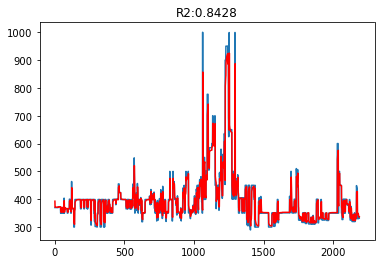

In [11]:
# for t in range(len(test_set)):
import numpy as np
import statsmodels.tsa.stattools as st
from scipy import stats
order = st.arma_order_select_ic(train_set,max_ar=5,max_ma=5,ic=['aic', 'bic', 'hqic'])
(p,q) = order.bic_min_order
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(train_set,order=(p,0,q)) 
results_AR = model.fit(disp=-1)
from sklearn.metrics import r2_score#R 2
r2 = r2_score(train_set,results_AR.fittedvalues)
plt.plot(train_set)
plt.plot(results_AR.fittedvalues, color='red') #红色线代表预测值
plt.title('R2:%.4f' % r2)#残差平方和

In [55]:
len(results_AR.fittedvalues)

2189

100%|██████████| 24/24 [00:09<00:00,  2.55it/s]


Text(0.5, 1.0, 'MAPE:0.0842')

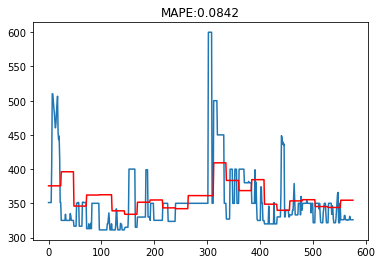

In [68]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from tqdm import tqdm
history = list(train_set)
prediction = list()

for t in tqdm(range(len(test_set)//24)):
#     order = st.arma_order_select_ic(history,max_ar=5,max_ma=5,ic=['aic', 'bic', 'hqic'])
#     (p,q) = order.bic_min_order
    model = ARIMA(history, order=(2,0,1))
    model_fit=model.fit(disp=0)
    output = model_fit.forecast(steps=24)
    yhat = output[0]
    for ele in list(yhat):
        prediction.append(yhat.mean())
    obs = test_set[t*24:(t+1)*24]
    for ele in obs:
        history.append(ele)
    
from sklearn.metrics import r2_score#R 2
from sklearn.metrics import mean_absolute_percentage_error
r2 = r2_score(test_set,prediction)
mape = mean_absolute_percentage_error(test_set,prediction)
plt.plot(test_set)
plt.plot(prediction, color='red') #红色线代表预测值
plt.title('MAPE:%.4f' % mape)#残差平方和



100%|██████████| 576/576 [03:53<00:00,  2.46it/s]


Text(0.5, 1.0, 'MAPE:0.0858')

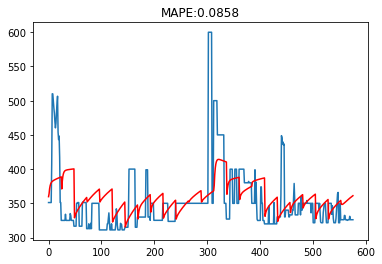

In [71]:
# append each prediction to histroy to retrain model. And then predict next

import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from tqdm import tqdm
history = list(train_set)
prediction = list()

for t in tqdm(range(len(test_set))):
#     order = st.arma_order_select_ic(history,max_ar=5,max_ma=5,ic=['aic', 'bic', 'hqic'])
#     (p,q) = order.bic_min_order
    model = ARIMA(history, order=(2,0,1))
    model_fit=model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    prediction.append(yhat)
    history.append(yhat)
    if t%24 == 0:
        history = history[:-24]
        obs = test_set[t-24:t]
        for ele in obs:
            history.append(ele)
from sklearn.metrics import r2_score#R 2
from sklearn.metrics import mean_absolute_percentage_error
r2 = r2_score(test_set,prediction)
mape = mean_absolute_percentage_error(test_set,prediction)
plt.plot(test_set)
plt.plot(prediction, color='red') #红色线代表预测值
plt.title('MAPE:%.4f' % mape)#残差平方和



100%|██████████| 576/576 [03:58<00:00,  2.41it/s]


Text(0.5, 1.0, 'R2:0.7853')

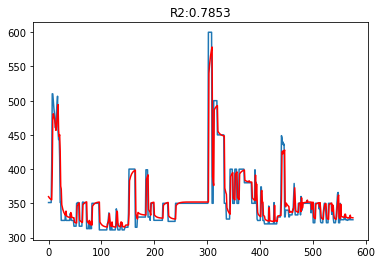

In [72]:
history = list(train_set)
prediction = list()

for t in tqdm(range(len(test_set))):
#     order = st.arma_order_select_ic(history,max_ar=5,max_ma=5,ic=['aic', 'bic', 'hqic'])
#     (p,q) = order.bic_min_order
    model = ARIMA(history, order=(2,0,1))
    model_fit=model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    prediction.append(yhat)
    obs = test_set[t]
    history.append(obs)
from sklearn.metrics import r2_score#R 2
r2 = r2_score(test_set,prediction)
plt.plot(test_set)
plt.plot(prediction, color='red') #红色线代表预测值
plt.title('R2:%.4f' % r2)#残差平方和